# Análise e Predição de Geração Solar - PQU_GOGO_GD

Notebook para treinar modelo de Machine Learning especializado no conjunto de usinas PQU_GOGO_GD.

Este notebook:
1. Le dados historicos de geracao do conjunto de usinas PQU_GOGO_GD
2. Prepara os dados
3. Divide dados em treino e teste
4. Treina um modelo Random Forest especializado
5. Avalia a performance do modelo
6. Usa o modelo treinado para previsão


## 1. Imports e Configuração

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import joblib
from datetime import datetime, timedelta
import os
import snowflake.connector
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Configurações do Projeto

In [22]:
# === CONFIGURAÇÕES DO MODELO ===

# Features usadas no modelo
FEATURES_MODELO = [
    "hora",
    "dia_semana",
    "mes",
    "ano",
    "trimestre",
    "semana_do_ano",
    "dias_desde_inicio",
    "plano_horizontal",
    "angulo_latitude",
    "maior_media_anual",
    "maior_minimo_mensal",
    "media",
    "delta",
]

# Coluna target
TARGET = "geracao_mw"

# Parâmetros do Random Forest (com regularização)
RANDOM_FOREST_PARAMS = {
    "n_estimators": 50,
    "max_depth": 20,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "random_state": 42,
    "n_jobs": -1,
}

# Proporção de dados para treinamento
PROPORCAO_TREINO = 0.8

## 2. Funções Utilitárias

In [23]:
def conectar_snowflake():
    """Estabelece conexão com o Snowflake."""
    load_dotenv()
    
    conn = snowflake.connector.connect(
        user=os.getenv("SNOWFLAKE_USER"),
        password=os.getenv("SNOWFLAKE_PASSWORD"),
        account=os.getenv("SNOWFLAKE_ACCOUNT"),
        warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
        database=os.getenv("SNOWFLAKE_DATABASE"),
        schema=os.getenv("SNOWFLAKE_SCHEMA"),
    )
    return conn


def carregar_irradiacao_snowflake(conn, uf='GO'):
    """
    Carrega dados de irradiação solar do Snowflake de forma dinâmica.
    
    Args:
        conn: Conexão ativa com o Snowflake
        uf: Unidade Federativa (estado). Padrão: 'GO' (Goiás)
    
    Returns:
        Dict no formato: {1: {...}, 2: {...}, ..., 12: {...}}
        onde cada mês contém: plano_horizontal, angulo_latitude, 
        maior_media_anual, maior_minimo_mensal, media, delta
    """
    query = f"""
    SELECT 
        UF,
        TIPO_ANGULO,
        JANEIRO, FEVEREIRO, MARCO, ABRIL, MAIO, JUNHO,
        JULHO, AGOSTO, SETEMBRO, OUTUBRO, NOVEMBRO, DEZEMBRO,
        MEDIA, DELTA
    FROM {os.getenv('SNOWFLAKE_DATABASE')}.{os.getenv('SNOWFLAKE_SCHEMA')}.STG_IRRADIACAO_SOLAR
    WHERE UF = '{uf}'
    ORDER BY ID
    """
    
    df_irrad = pd.read_sql(query, conn)
    
    # Mapeamento dos tipos de ângulo
    mapeamento = {
        'Plano Horizontal': 'plano_horizontal',
        'Ângulo igual a latitude': 'angulo_latitude',
        'Maior média anual': 'maior_media_anual',
        'Maior mínimo mensal': 'maior_minimo_mensal'
    }
    
    # Nomes dos meses na tabela
    meses_nomes = ['JANEIRO', 'FEVEREIRO', 'MARCO', 'ABRIL', 'MAIO', 'JUNHO', 
                   'JULHO', 'AGOSTO', 'SETEMBRO', 'OUTUBRO', 'NOVEMBRO', 'DEZEMBRO']
    
    # Construir dicionário no formato esperado
    irradiacao_mensal = {}
    
    for mes_num in range(1, 13):
        mes_nome = meses_nomes[mes_num - 1]
        mes_data = {}
        
        # Extrair valores para cada tipo de ângulo
        for _, row in df_irrad.iterrows():
            tipo_key = mapeamento.get(row['TIPO_ANGULO'])
            if tipo_key:
                mes_data[tipo_key] = float(row[mes_nome])
        
        # Adicionar média e delta (são iguais para todos os tipos)
        mes_data['media'] = float(df_irrad.iloc[0]['MEDIA'])
        mes_data['delta'] = float(df_irrad.iloc[0]['DELTA'])
        
        irradiacao_mensal[mes_num] = mes_data
    
    return irradiacao_mensal


def criar_features_temporais(df):
    """
    Cria features temporais a partir da coluna data_hora.
    Função reutilizável para treino e predição.
    """
    df["hora"] = df["data_hora"].dt.hour
    df["dia_semana"] = df["data_hora"].dt.dayofweek + 1
    df["mes"] = df["data_hora"].dt.month
    df["data"] = df["data_hora"].dt.date
    df["ano"] = df["data_hora"].dt.year
    df["trimestre"] = df["data_hora"].dt.quarter
    df["semana_do_ano"] = df["data_hora"].dt.isocalendar().week
    
    # Dias desde o início do dataset
    data_inicial = df["data_hora"].min()
    df["dias_desde_inicio"] = (df["data_hora"] - data_inicial).dt.days
    
    return df


def adicionar_features_irradiacao(df, irradiacao_mensal):
    """
    Adiciona features de irradiação solar baseadas no mês.
    Função reutilizável para treino e predição.
    
    Args:
        df: DataFrame com coluna 'mes'
        irradiacao_mensal: Dicionário com dados de irradiação por mês
    """
    df["plano_horizontal"] = df["mes"].map(lambda m: irradiacao_mensal[m]["plano_horizontal"])
    df["angulo_latitude"] = df["mes"].map(lambda m: irradiacao_mensal[m]["angulo_latitude"])
    df["maior_media_anual"] = df["mes"].map(lambda m: irradiacao_mensal[m]["maior_media_anual"])
    df["maior_minimo_mensal"] = df["mes"].map(lambda m: irradiacao_mensal[m]["maior_minimo_mensal"])
    df["media"] = df["mes"].map(lambda m: irradiacao_mensal[m]["media"])
    df["delta"] = df["mes"].map(lambda m: irradiacao_mensal[m]["delta"])
    
    return df


def carregar_dados_snowflake():
    """
    Conecta ao Snowflake e carrega dados de geração solar da PQU_GOGO_GD.
    Retorna o DataFrame preparado e os dados de irradiação.
    """
    print("Conectando ao Snowflake...")
    
    try:
        conn = conectar_snowflake()
        print("✓ Conexão estabelecida")
        
        # Carregar dados de irradiação solar do Snowflake
        print("Carregando dados de irradiação solar do Snowflake...")
        irradiacao_mensal = carregar_irradiacao_snowflake(conn, uf='GO')
        print("✓ Dados de irradiação carregados dinamicamente")
        
        # Montar query para PQU_GOGO_GD a partir de 2024
        table_name = f"{os.getenv('SNOWFLAKE_DATABASE')}.{os.getenv('SNOWFLAKE_SCHEMA')}.{os.getenv('SNOWFLAKE_TABLE')}"
        
        query = f"""
        SELECT 
            id_ons as id_usina,
            instante as medicao_data_hora,
            val_geracao_mw as geracao_mwh
        FROM {table_name}
        WHERE id_ons = 'PQU_GOGO_GD'
            AND instante >= '2024-01-01'
        ORDER BY instante
        """
        
        print(f"Executando query em {table_name}...")
        df = pd.read_sql(query, conn)
        conn.close()
        
        # Renomear colunas
        df.columns = ["id_usina", "data_hora", "geracao_mw"]
        df["data_hora"] = pd.to_datetime(df["data_hora"])
        
        # Criar features temporais
        df = criar_features_temporais(df)
        
        # Adicionar features de irradiação solar (usando dados dinâmicos)
        df = adicionar_features_irradiacao(df, irradiacao_mensal)
        
        # Ordenar dados
        df = df.sort_values(["data_hora"]).reset_index(drop=True)
        
        print(f"\n✓ Dataset carregado: {len(df):,} registros")
        print(f"Período: {df['data_hora'].min()} até {df['data_hora'].max()}")
        
        return df, irradiacao_mensal
        
    except Exception as e:
        print(f"Erro ao conectar ao Snowflake: {e}")
        raise

In [24]:
def split_treino_teste(df):
    """
    Divide dados em conjunto de treino e teste (temporal).
    """
    print("\nDividindo dados em treino e teste...")

    # Split temporal: primeiros 80% dos dias para treino
    total_dias = df["data"].nunique()
    dias_treino = int(total_dias * PROPORCAO_TREINO)

    # Encontrar a data de corte
    datas_unicas = sorted(df["data"].unique())
    data_corte = datas_unicas[dias_treino - 1]

    # Dividir dados
    treino = df[df["data"] <= data_corte].copy()
    teste = df[df["data"] > data_corte].copy()

    print(f"Período treino: {treino['data'].min()} até {treino['data'].max()}")
    print(f"Período teste: {teste['data'].min()} até {teste['data'].max()}")
    print(f"Registros treino: {len(treino):,} ({len(treino) / len(df) * 100:.1f}%)")
    print(f"Registros teste: {len(teste):,} ({len(teste) / len(df) * 100:.1f}%)")

    return treino, teste

In [25]:
def avaliar_modelo(y_true, y_pred, nome="Modelo"):
    """
    Calcula métricas de avaliação do modelo.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== Métricas do {nome} ===")
    print(f"MAE (Mean Absolute Error): {mae:.2f} MW")
    print(f"RMSE (Root Mean Square Error): {rmse:.2f} MW")
    print(f"R2 Score: {r2:.4f}")

    return {"mae": mae, "rmse": rmse, "r2": r2}

## 3. Carregamento e Preparação dos Dados

In [26]:
# Carregar dados do Snowflake (incluindo dados de irradiação dinâmicos)
df, irradiacao_mensal = carregar_dados_snowflake()

Conectando ao Snowflake...
✓ Conexão estabelecida
Carregando dados de irradiação solar do Snowflake...


/var/folders/s1/4m1vxl4161zb97br9zvv8cnm0000gn/T/ipykernel_39966/2222127610.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_irrad = pd.read_sql(query, conn)


✓ Dados de irradiação carregados dinamicamente
Executando query em IE_DB.STAGING.stg_usina_geracao...


/var/folders/s1/4m1vxl4161zb97br9zvv8cnm0000gn/T/ipykernel_39966/2222127610.py:147: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



✓ Dataset carregado: 15,216 registros
Período: 2024-01-01 00:00:00 até 2025-09-25 23:00:00


In [27]:
# Dividir em treino/teste
treino, teste = split_treino_teste(df)


Dividindo dados em treino e teste...
Período treino: 2024-01-01 até 2025-05-21
Período teste: 2025-05-22 até 2025-09-25
Registros treino: 12,168 (80.0%)
Registros teste: 3,048 (20.0%)


In [28]:
# Separar features (X) e target (y)
X_train = treino[FEATURES_MODELO]
y_train = treino[TARGET]
X_test = teste[FEATURES_MODELO]
y_test = teste[TARGET]

print(f"\nFeatures utilizadas: {FEATURES_MODELO}")
print(f"Shape treino: {X_train.shape}")
print(f"Shape teste: {X_test.shape}")


Features utilizadas: ['hora', 'dia_semana', 'mes', 'ano', 'trimestre', 'semana_do_ano', 'dias_desde_inicio', 'plano_horizontal', 'angulo_latitude', 'maior_media_anual', 'maior_minimo_mensal', 'media', 'delta']
Shape treino: (12168, 13)
Shape teste: (3048, 13)


## 4. Validação e Treinamento do Modelo

Usa **TimeSeriesSplit** para validar o modelo em múltiplos períodos temporais e avaliar sua estabilidade ao longo do tempo.

In [29]:
# Configurar TimeSeriesSplit (10 splits temporais)
tscv = TimeSeriesSplit(n_splits=10)

# Criar modelo para validação
rf_validacao = RandomForestRegressor(**RANDOM_FOREST_PARAMS)

print("=== Validação Temporal com TimeSeriesSplit ===")
print("Avaliando o modelo em 10 períodos temporais diferentes...\n")

# Executar validação cruzada temporal
scores = cross_val_score(
    rf_validacao, 
    X_train, 
    y_train, 
    cv=tscv, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Converter scores para valores positivos (MAE)
maes = -scores

print("=== Performance por Fold (TimeSeriesSplit) ===")
print("Cada fold representa um período temporal progressivo:\n")

for i, mae in enumerate(maes, 1):
    print(f"Fold {i}: MAE = {mae:.2f} MW")

print(f"\nMédia: {maes.mean():.2f} MW")
print(f"Desvio padrão: {maes.std():.2f} MW")
print(f"\n→ Desvio padrão {'baixo' if maes.std() < 50 else 'alto'}: modelo {'estável' if maes.std() < 50 else 'varia'} em diferentes períodos temporais")

=== Validação Temporal com TimeSeriesSplit ===
Avaliando o modelo em 10 períodos temporais diferentes...

=== Performance por Fold (TimeSeriesSplit) ===
Cada fold representa um período temporal progressivo:

Fold 1: MAE = 65.94 MW
Fold 2: MAE = 29.75 MW
Fold 3: MAE = 21.17 MW
Fold 4: MAE = 28.41 MW
Fold 5: MAE = 27.13 MW
Fold 6: MAE = 67.82 MW
Fold 7: MAE = 76.18 MW
Fold 8: MAE = 62.09 MW
Fold 9: MAE = 55.97 MW
Fold 10: MAE = 48.02 MW

Média: 48.25 MW
Desvio padrão: 19.09 MW

→ Desvio padrão baixo: modelo estável em diferentes períodos temporais


In [30]:
# Treinar Random Forest no conjunto de treino completo
print("\n" + "="*60)
print("TREINAMENTO DO MODELO ESPECIALIZADO - PQU_GOGO_GD")
print("="*60)

rf = RandomForestRegressor(**RANDOM_FOREST_PARAMS)
rf.fit(X_train, y_train)

print("\n✓ Treinamento concluído!")


TREINAMENTO DO MODELO ESPECIALIZADO - PQU_GOGO_GD

✓ Treinamento concluído!


In [31]:
# Fazer predições
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [32]:
# Avaliar modelo
metricas_treino = avaliar_modelo(y_train, y_train_pred, "Treino")
metricas_teste = avaliar_modelo(y_test, y_test_pred, "Teste")


=== Métricas do Treino ===
MAE (Mean Absolute Error): 16.43 MW
RMSE (Root Mean Square Error): 37.89 MW
R2 Score: 0.9893

=== Métricas do Teste ===
MAE (Mean Absolute Error): 38.28 MW
RMSE (Root Mean Square Error): 70.84 MW
R2 Score: 0.9794


In [33]:
# Importância das features
print("\n=== Importância das Features ===")
print("(Quanto maior o valor, mais importante a feature para o modelo)")
feature_importance = pd.DataFrame(
    {"feature": FEATURES_MODELO, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)

for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


=== Importância das Features ===
(Quanto maior o valor, mais importante a feature para o modelo)
hora: 0.9089
dias_desde_inicio: 0.0801
semana_do_ano: 0.0042
dia_semana: 0.0022
maior_minimo_mensal: 0.0010
mes: 0.0009
plano_horizontal: 0.0009
angulo_latitude: 0.0007
maior_media_anual: 0.0007
trimestre: 0.0005
ano: 0.0000
media: 0.0000
delta: 0.0000


In [34]:
# Salvar modelo treinado
joblib.dump(rf, "modelo_gogo.pkl")
print(f"\nModelo salvo em: modelo_gogo.pkl")

# Salvar resultados
resultado = teste[["id_usina", "data_hora", "geracao_mw"]].copy()
resultado["predicao"] = y_test_pred
resultado["erro_absoluto"] = abs(resultado["geracao_mw"] - resultado["predicao"])
resultado.to_csv("predicoes_teste_gogo.csv", index=False)
print(f"Predições de teste salvas em: predicoes_teste_gogo.csv")

# Salvar datasets preparados
treino.to_csv("dados_treino_gogo.csv", index=False)
teste.to_csv("dados_teste_gogo.csv", index=False)
print(f"Dados preparados salvos: dados_treino_gogo.csv e dados_teste_gogo.csv")


Modelo salvo em: modelo_gogo.pkl
Predições de teste salvas em: predicoes_teste_gogo.csv
Dados preparados salvos: dados_treino_gogo.csv e dados_teste_gogo.csv


## 5. Sistema de Predição

In [35]:
class PrevisaoGeracao:
    """
    Sistema de previsão de geração solar para PQU_GOGO_GD.
    """

    def __init__(self, caminho_modelo="modelo_gogo.pkl", irradiacao_mensal=None):
        """
        Inicializa o sistema de previsão.
        
        Args:
            caminho_modelo: Caminho para o modelo treinado
            irradiacao_mensal: Dicionário com dados de irradiação por mês.
                              Se None, carrega do Snowflake automaticamente.
        """
        self.modelo = joblib.load(caminho_modelo)
        
        # Se não foi fornecido, carregar dados de irradiação do Snowflake
        if irradiacao_mensal is None:
            print("Carregando dados de irradiação do Snowflake...")
            conn = conectar_snowflake()
            self.irradiacao_mensal = carregar_irradiacao_snowflake(conn, uf='GO')
            conn.close()
            print("✓ Dados de irradiação carregados")
        else:
            self.irradiacao_mensal = irradiacao_mensal

    def prever_meses_futuros(self, data_inicio, num_meses=12):
        """
        Faz predição de geração para múltiplos meses consecutivos.
        Retorna a média horária de geração para cada mês.
        
        Args:
            data_inicio: Data inicial (string YYYY-MM-DD ou datetime)
            num_meses: Número de meses a prever (padrão: 12)
            
        Returns:
            Dict com dados agregados por mês e hora
        """
        # Validar e converter data
        if isinstance(data_inicio, str):
            data_base = pd.to_datetime(data_inicio)
        else:
            data_base = data_inicio

        print(f"\nGerando previsões para {num_meses} meses a partir de {data_base.strftime('%Y-%m-%d')}...\n")
        
        resultados_meses = []
        
        for i in range(num_meses):
            # Calcular range do mês
            if i == 0:
                mes_atual = data_base
            else:
                mes_atual = data_base + pd.DateOffset(months=i)
            
            primeiro_dia = mes_atual.replace(day=1)
            
            # Último dia do mês
            if primeiro_dia.month == 12:
                ultimo_dia = primeiro_dia.replace(day=31)
            else:
                proximo_mes = primeiro_dia + pd.DateOffset(months=1)
                ultimo_dia = proximo_mes - timedelta(days=1)
            
            print(f"Mês {i+1}: {primeiro_dia.strftime('%B/%Y')} ({primeiro_dia.strftime('%Y-%m-%d')} a {ultimo_dia.strftime('%Y-%m-%d')})")
            
            # Gerar predições para cada dia do mês
            datas_mes = pd.date_range(start=primeiro_dia, end=ultimo_dia, freq='D')
            predicoes_por_hora = {hora: [] for hora in range(24)}
            
            for data in datas_mes:
                predicoes_dia = self._prever_dia(data)
                
                for pred in predicoes_dia:
                    predicoes_por_hora[pred["hora"]].append(pred["geracao_mw"])
            
            # Calcular média horária para o mês
            media_horaria_mes = []
            for hora in range(24):
                media = np.mean(predicoes_por_hora[hora]) if predicoes_por_hora[hora] else 0
                media_horaria_mes.append({
                    "hora": hora,
                    "geracao_media_mw": round(media, 2)
                })
            
            # Estatísticas do mês
            geracoes_medias = [p["geracao_media_mw"] for p in media_horaria_mes]
            total_mensal = sum(geracoes_medias) * len(datas_mes)
            pico_medio = max(geracoes_medias)
            hora_pico = geracoes_medias.index(pico_medio)
            
            resultado_mes = {
                "mes": primeiro_dia.month,
                "ano": primeiro_dia.year,
                "mes_nome": primeiro_dia.strftime('%B/%Y'),
                "mes_abrev": primeiro_dia.strftime('%b/%Y'),
                "dias_no_mes": len(datas_mes),
                "media_horaria": media_horaria_mes,
                "estatisticas": {
                    "total_mensal_estimado_mwh": round(total_mensal, 2),
                    "pico_medio_mw": round(pico_medio, 2),
                    "horario_pico_medio": hora_pico,
                    "media_diaria_mwh": round(sum(geracoes_medias), 2)
                }
            }
            
            resultados_meses.append(resultado_mes)
            print(f"  ✓ Pico médio: {pico_medio:.2f} MW às {hora_pico}h | Total mensal: {total_mensal:.2f} MWh\n")
        
        print(f"✓ Previsão concluída para {num_meses} meses!\n")
        
        return {
            "data_inicio": data_base.strftime("%Y-%m-%d"),
            "num_meses": num_meses,
            "meses": resultados_meses
        }

    def _prever_dia(self, data):
        """
        Predição interna para todas as 24 horas de um dia.
        
        Args:
            data: datetime do dia
            
        Returns:
            Lista de predições horárias
        """
        # Extrair features temporais
        mes = data.month
        ano = data.year
        dia_semana = data.dayofweek + 1
        trimestre = data.quarter
        semana_do_ano = data.isocalendar().week
        
        # Dias desde o início (baseado em 2024-01-01)
        data_inicial = pd.to_datetime("2024-01-01")
        dias_desde_inicio = (data - data_inicial).days
        
        # Dados de irradiação do mês (usando dados dinâmicos)
        irradiacao = self.irradiacao_mensal[mes]
        
        predicoes_horarias = []
        
        for hora in range(24):
            # Criar DataFrame com features
            features_df = pd.DataFrame(
                [[
                    hora,
                    dia_semana,
                    mes,
                    ano,
                    trimestre,
                    semana_do_ano,
                    dias_desde_inicio,
                    irradiacao["plano_horizontal"],
                    irradiacao["angulo_latitude"],
                    irradiacao["maior_media_anual"],
                    irradiacao["maior_minimo_mensal"],
                    irradiacao["media"],
                    irradiacao["delta"],
                ]],
                columns=FEATURES_MODELO
            )
            
            # Predição
            predicao = self.modelo.predict(features_df)[0]
            predicao = max(0, predicao)
            
            predicoes_horarias.append({
                "hora": hora,
                "geracao_mw": round(predicao, 2)
            })
        
        return predicoes_horarias

## 6. Visualização

In [36]:
def plotar_curva_mensal(resultado_previsao, salvar=True, nome_arquivo=None):
    """
    Cria gráfico de curva de geração média horária para múltiplos meses.
    
    Args:
        resultado_previsao: Resultado da função prever_meses_futuros()
        salvar: Se True, salva o gráfico em arquivo PNG
        nome_arquivo: Nome do arquivo (opcional, gerado automaticamente se None)
    """
    plt.figure(figsize=(16, 9))
    
    # Paleta de cores para até 12 meses
    cores = [
        '#4472C4', '#ED7D31', '#A5A5A5', '#FFC000', '#70AD47', '#5B9BD5',
        '#C55A11', '#9E480E', '#636363', '#997300', '#43682B', '#264478'
    ]
    
    # Plotar cada mês
    for idx, mes_data in enumerate(resultado_previsao['meses']):
        horas = [h['hora'] for h in mes_data['media_horaria']]
        geracoes = [h['geracao_media_mw'] for h in mes_data['media_horaria']]
        
        plt.plot(
            horas, 
            geracoes, 
            label=mes_data['mes_abrev'],
            linewidth=2.0,
            color=cores[idx % len(cores)]
        )
    
    # Formatação
    plt.title('Geração Média Horária (MWmed) - PQU_GOGO_GD', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hora do Dia', fontsize=12, fontweight='bold')
    plt.ylabel('Geração de Energia (MW)', fontsize=12, fontweight='bold')
    plt.xticks(range(0, 24, 1), [f'{h:02d}:00' for h in range(0, 24, 1)], rotation=45, ha='right')
    plt.ylim(0, None)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    num_colunas = 2 if len(resultado_previsao['meses']) > 6 else 1
    plt.legend(loc='upper right', fontsize=10, framealpha=0.9, ncol=num_colunas)
    plt.tight_layout()
    
    # Salvar arquivo
    if salvar:
        if nome_arquivo is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            num_meses = len(resultado_previsao['meses'])
            nome_arquivo = f'curva_geracao_{num_meses}meses_PQU-GOGO-GD_{timestamp}.png'
        
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        print(f"\nGráfico salvo em: {nome_arquivo}")
    
    plt.show()
    return plt.gcf()

## 7. Exemplo de Uso - Predição para Múltiplos Meses

In [37]:
# Inicializar sistema de predição (passando dados de irradiação já carregados)
sistema = PrevisaoGeracao(irradiacao_mensal=irradiacao_mensal)

# Fazer predição para 12 meses futuros consecutivos
resultado_12_meses = sistema.prever_meses_futuros(
    data_inicio='2025-10-01',  # Primeiro dia do mês a prever
    num_meses=12
)


Gerando previsões para 12 meses a partir de 2025-10-01...

Mês 1: October/2025 (2025-10-01 a 2025-10-31)
  ✓ Pico médio: 1266.77 MW às 11h | Total mensal: 268615.62 MWh

Mês 2: November/2025 (2025-11-01 a 2025-11-30)
  ✓ Pico médio: 1261.99 MW às 11h | Total mensal: 264339.60 MWh

Mês 3: December/2025 (2025-12-01 a 2025-12-31)
  ✓ Pico médio: 1258.19 MW às 11h | Total mensal: 272738.62 MWh

Mês 4: January/2026 (2026-01-01 a 2026-01-31)
  ✓ Pico médio: 1236.90 MW às 11h | Total mensal: 271464.21 MWh

Mês 5: February/2026 (2026-02-01 a 2026-02-28)
  ✓ Pico médio: 1243.15 MW às 11h | Total mensal: 244251.00 MWh

Mês 6: March/2026 (2026-03-01 a 2026-03-31)
  ✓ Pico médio: 1259.65 MW às 11h | Total mensal: 274382.24 MWh

Mês 7: April/2026 (2026-04-01 a 2026-04-30)
  ✓ Pico médio: 1260.70 MW às 11h | Total mensal: 255623.10 MWh

Mês 8: May/2026 (2026-05-01 a 2026-05-31)
  ✓ Pico médio: 1280.11 MW às 11h | Total mensal: 271152.97 MWh

Mês 9: June/2026 (2026-06-01 a 2026-06-30)
  ✓ Pico médio


Gráfico salvo em: curva_geracao_12meses_PQU-GOGO-GD_20251018_143020.png


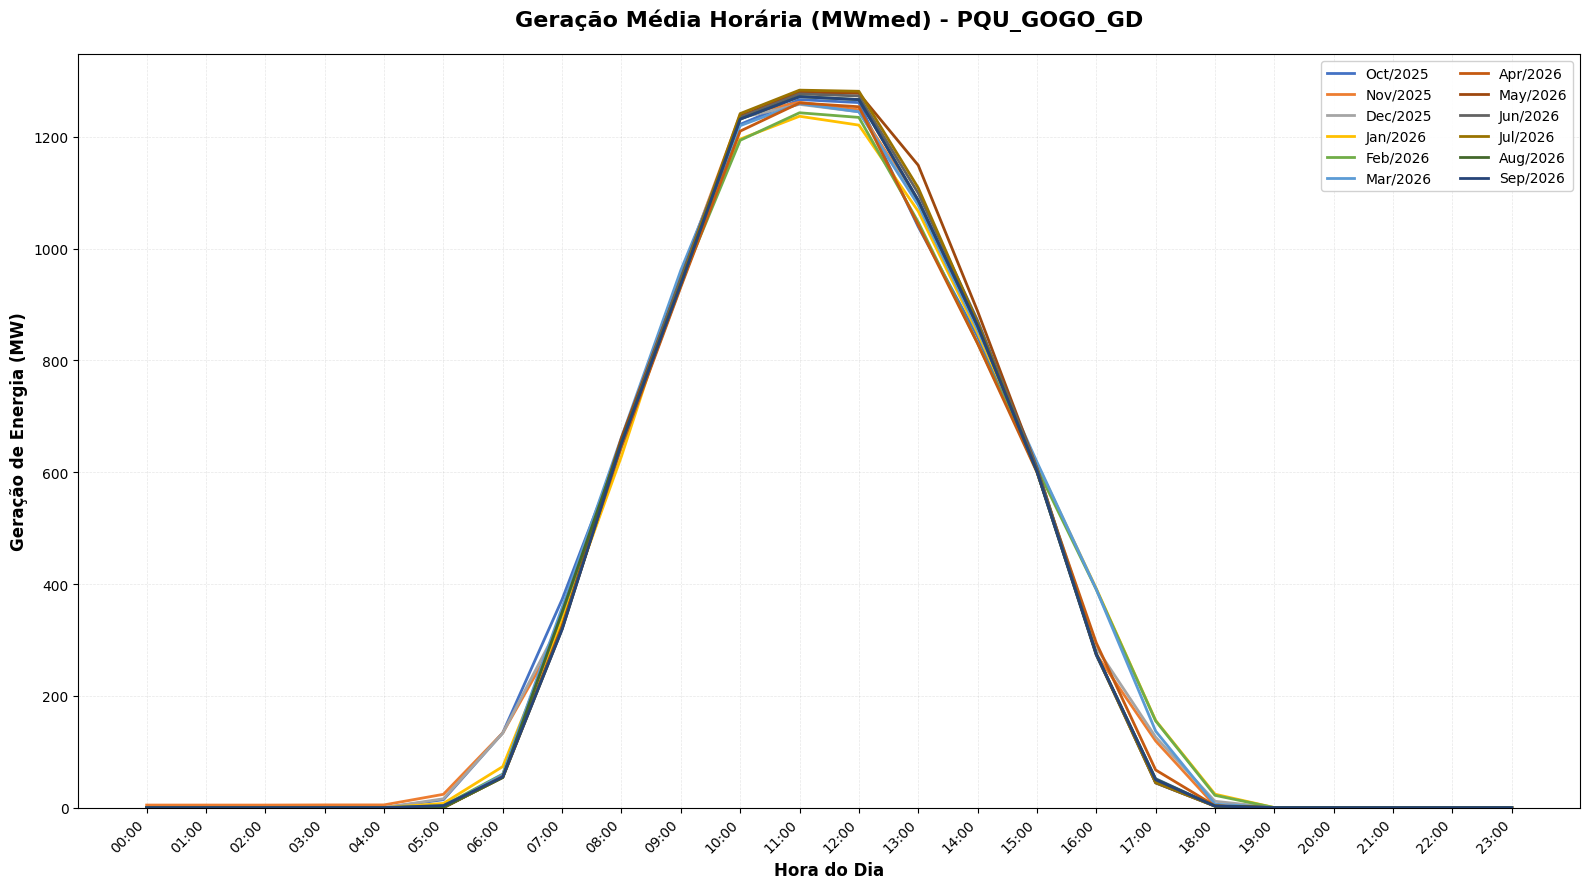

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [38]:
# Plotar curva de geração média horária para os 12 meses
plotar_curva_mensal(resultado_12_meses, salvar=True)

In [39]:
# Exibir resumo estatístico dos 12 meses
print("="*70)
print("RESUMO DA PREVISÃO - PQU_GOGO_GD")
print("="*70)

for mes_data in resultado_12_meses['meses']:
    print(f"\n{mes_data['mes_nome']} ({mes_data['dias_no_mes']} dias)")
    print(f"  • Pico médio: {mes_data['estatisticas']['pico_medio_mw']:.2f} MW às {mes_data['estatisticas']['horario_pico_medio']}h")
    print(f"  • Média diária: {mes_data['estatisticas']['media_diaria_mwh']:.2f} MWh/dia")
    print(f"  • Total mensal estimado: {mes_data['estatisticas']['total_mensal_estimado_mwh']:.2f} MWh")

print("\n" + "="*70)

RESUMO DA PREVISÃO - PQU_GOGO_GD

October/2025 (31 dias)
  • Pico médio: 1266.77 MW às 11h
  • Média diária: 8665.02 MWh/dia
  • Total mensal estimado: 268615.62 MWh

November/2025 (30 dias)
  • Pico médio: 1261.99 MW às 11h
  • Média diária: 8811.32 MWh/dia
  • Total mensal estimado: 264339.60 MWh

December/2025 (31 dias)
  • Pico médio: 1258.19 MW às 11h
  • Média diária: 8798.02 MWh/dia
  • Total mensal estimado: 272738.62 MWh

January/2026 (31 dias)
  • Pico médio: 1236.90 MW às 11h
  • Média diária: 8756.91 MWh/dia
  • Total mensal estimado: 271464.21 MWh

February/2026 (28 dias)
  • Pico médio: 1243.15 MW às 11h
  • Média diária: 8723.25 MWh/dia
  • Total mensal estimado: 244251.00 MWh

March/2026 (31 dias)
  • Pico médio: 1259.65 MW às 11h
  • Média diária: 8851.04 MWh/dia
  • Total mensal estimado: 274382.24 MWh

April/2026 (30 dias)
  • Pico médio: 1260.70 MW às 11h
  • Média diária: 8520.77 MWh/dia
  • Total mensal estimado: 255623.10 MWh

May/2026 (31 dias)
  • Pico médio: 1